### RMOTR FINAL PROJECT
##### STACKOVERFLOW 2018 SURVEY RESULT ANALYSIS

In [1]:
# Initiliaze Common Packages/Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from zipfile import ZipFile
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam


import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize': (14, 7)})

Using TensorFlow backend.


In [2]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [3]:
df_public = pd.read_csv('data/survey_results_public.csv')
df_schema = pd.read_csv('data/survey_results_schema.csv')

## Summary of the Dataset:
## The dataset contians answers to various questions asked to respondents who have used StackOverflow. 
## Questions include categories about the respondent (for example: Which country they're from, what race they are, what's their education background, etc.)
## Additional there are questions that dive in deeper into respondent's sentiment about career, and skills they use related to coding.
## there are also behavioral questions about the respondents which can help us understand who that person is.


In [4]:
df_public.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98855 entries, 0 to 98854
Columns: 129 entries, Respondent to SurveyEasy
dtypes: float64(41), int64(1), object(87)
memory usage: 97.3+ MB


## Question 5

#### Which are the most popular programming languages? And which are the highest-paying ones?

The first question pertains to determing what the most popular programming langauges. To answer that, we're going to count the unique occurances of each langauge. 

In [5]:
df = pd.read_csv('data/survey_results_public.csv')

After pulling in all the CSV, first step was to split the LanguageWorkedWith column into into unique values

In [6]:
all_langs = df['LanguageWorkedWith'].str.split(';', expand=True).stack().unique()
all_langs

array(['JavaScript', 'Python', 'HTML', 'CSS', 'Bash/Shell', 'C#', 'SQL',
       'TypeScript', 'C', 'C++', 'Java', 'Matlab', 'R', 'Assembly',
       'CoffeeScript', 'Erlang', 'Go', 'Lua', 'Ruby', 'PHP', 'VB.NET',
       'Swift', 'Groovy', 'Kotlin', 'Objective-C', 'Scala', 'F#',
       'Haskell', 'Rust', 'Julia', 'VBA', 'Perl', 'Cobol',
       'Visual Basic 6', 'Delphi/Object Pascal', 'Hack', 'Clojure',
       'Ocaml'], dtype=object)

Next, create a series by looping through the all_langs object and use the sum function to add up instances

In [7]:
langtype_count = pd.Series([df.loc[:, 'LanguageWorkedWith'].str.contains(lang, regex=False).sum()
                           for lang in all_langs],
                          index=all_langs,
                          name='LangType_count')

langtype_count = langtype_count.sort_values(ascending=False)

langtype_count

C                       67063
Java                    64912
JavaScript              54686
HTML                    53628
CSS                     50979
SQL                     44670
Bash/Shell              31172
Python                  30359
C#                      26954
PHP                     24071
C++                     19872
TypeScript              13626
R                       13348
Ruby                     7911
Swift                    6310
Assembly                 5760
Go                       5532
Objective-C              5510
VB.NET                   5254
Matlab                   4564
VBA                      3810
Kotlin                   3508
Scala                    3420
Groovy                   3373
Perl                     3280
Visual Basic 6           3087
Lua                      2733
CoffeeScript             2603
Delphi/Object Pascal     2025
Haskell                  1961
Rust                     1857
F#                       1115
Clojure                  1032
Erlang    

Barchart time. 

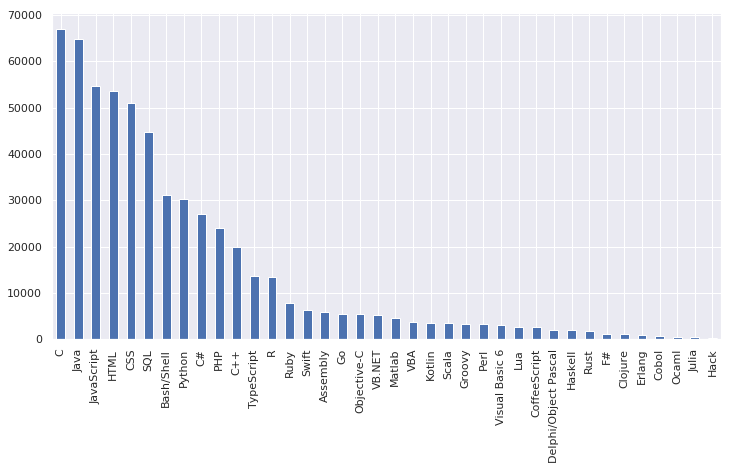

In [8]:
langtype_count.plot(kind='bar', figsize=(12, 6))

In [9]:
langtype_index = pd.Series([df.loc[:, 'LanguageWorkedWith'].str.contains(lang, regex=False)
                           for lang in all_langs],
                          index=all_langs,
                          name='LangType_count')

Just like before, we're looping through occurances. But this time, we're looking at `ConvertedSalary` and finding the median. This will tell us which language has the highest average salary. This is the indidicator as to what language relates to the highest salary. 

In [10]:
langtype_salary = pd.Series([df[langtype_index[i].fillna(False)]['ConvertedSalary'].median()
                            for i in np.arange(len(all_langs))],
                           index=all_langs,
                           name='LangType_ConvertedSalary')

langtype_salary = langtype_salary.sort_values(ascending=False)

langtype_salary

Clojure                 82904.0
F#                      80366.5
Go                      75175.0
Hack                    75000.0
Groovy                  75000.0
Scala                   73906.0
Erlang                  73596.0
Perl                    73433.0
Ruby                    72696.0
Rust                    72230.0
CoffeeScript            70000.0
Ocaml                   70000.0
R                       68537.0
Bash/Shell              64866.0
Julia                   63642.0
Objective-C             62418.0
TypeScript              62412.0
Python                  60000.0
Lua                     59980.0
Swift                   59970.0
C#                      59000.0
Cobol                   58749.0
SQL                     56400.0
JavaScript              56298.0
C                       55562.0
Haskell                 55562.0
Java                    55075.0
Kotlin                  55075.0
VBA                     55000.0
CSS                     55000.0
HTML                    55000.0
VB.NET  

Clojure, F#, and Go? Didn't see that coming. Guessing that probably has something to do with the relative rarity of those langauges.

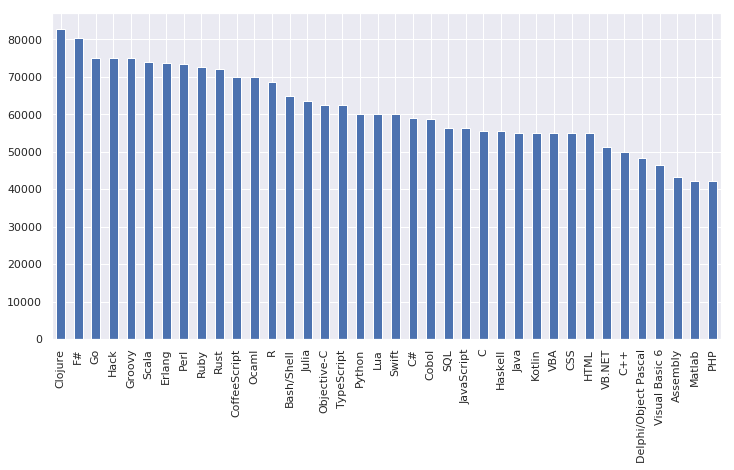

In [11]:
langtype_salary.plot(kind='bar', figsize=(12, 6))

## Question 6
#### Are the best paid jobs the most satisfying?

Here we're looking not at the jobs, but at three key factors - salary, and our two satisifcation measures. 

In [38]:
q_df = df_public.loc[:,[
      'ConvertedSalary'
    , 'JobSatisfaction'
    , 'CareerSatisfaction'
]]

A quick peek at the data

In [13]:
q_df.head()

,ConvertedSalary,JobSatisfaction,CareerSatisfaction
0,NaN,Extremely satisfied,Extremely satisfied
1,70841.0,Moderately dissatisfied,Neither satisfied nor dissatisfied
2,NaN,Moderately satisfied,Moderately satisfied
3,NaN,Neither satisfied nor dissatisfied,Slightly dissatisfied
4,21426.0,Slightly satisfied,Moderately satisfied


And a look at the info to see how many non non-null values each column has. Looks like roughly half the respondants didn't have a salary. 

In [14]:
q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98855 entries, 0 to 98854
Data columns (total 3 columns):
ConvertedSalary       47702 non-null float64
JobSatisfaction       69276 non-null object
CareerSatisfaction    76504 non-null object
dtypes: float64(1), object(2)
memory usage: 2.3+ MB


Since `ConvertedSalary` was the bulk of NaN values, I took a gamble and just dropped all null values.

In [39]:
q_df.dropna(inplace=True)

In [40]:
q_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45181 entries, 1 to 80449
Data columns (total 3 columns):
ConvertedSalary       45181 non-null float64
JobSatisfaction       45181 non-null object
CareerSatisfaction    45181 non-null object
dtypes: float64(1), object(2)
memory usage: 1.4+ MB


Another quick peek at the leftover data. 

In [18]:
for col in q_df.columns:
    print('Column: {} | Values: {}'.format(col, q_df[col].unique()))

Column: ConvertedSalary | Values: [ 70841.  21426.  41671. ... 156748. 150144.  77928.]
Column: JobSatisfaction | Values: ['Moderately dissatisfied' 'Slightly satisfied' 'Moderately satisfied'
 'Neither satisfied nor dissatisfied' 'Slightly dissatisfied'
 'Extremely dissatisfied' 'Extremely satisfied']
Column: CareerSatisfaction | Values: ['Neither satisfied nor dissatisfied' 'Moderately satisfied'
 'Slightly satisfied' 'Moderately dissatisfied' 'Slightly dissatisfied'
 'Extremely satisfied' 'Extremely dissatisfied']


Now we establish salary quartiles

In [19]:
q1 = q_df['ConvertedSalary'].quantile(0.25)
q3 = q_df['ConvertedSalary'].quantile(0.75)
IQR = q3 - q1
print(q1, q3, IQR)

26925.0 95000.0 68075.0


#### REMOVE ROWS WITH OUTLIER SALARIES

In [20]:
ub = q_df['ConvertedSalary'] <= (q3 + (1.5 * IQR))

q_df = q_df[ub]

As you can see in the boxplot, we didn't quite get rid of all outliars, but we trimmed the most egregious. 

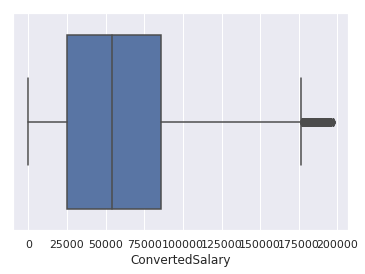

In [21]:
sns.boxplot(q_df['ConvertedSalary'])

#### Create Categories

Next, it's time to turn string values into ordered categories so we can create some groups

In [47]:
q_df['JobSatisfaction'] = q_df['JobSatisfaction'].astype(CategoricalDtype([
    'Extremely dissatisfied',
    'Moderately dissatisfied',
    'Slightly dissatisfied', 
    'Neither satisfied nor dissatisfied',
    'Slightly satisfied',
    'Moderately satisfied',
    'Extremely satisfied'    
], ordered=True))

In [48]:
q_df['CareerSatisfaction'] = q_df['CareerSatisfaction'].astype(CategoricalDtype([
    'Extremely dissatisfied',
    'Moderately dissatisfied',
    'Slightly dissatisfied', 
    'Neither satisfied nor dissatisfied',
    'Slightly satisfied',
    'Moderately satisfied',
    'Extremely satisfied'    
], ordered=True))

In [49]:
cat_columns = q_df.select_dtypes(['category']).columns
cat_columns

Index(['JobSatisfaction', 'CareerSatisfaction'], dtype='object')

In [50]:
q_df[cat_columns] = q_df[cat_columns].apply(lambda x: x.cat.codes)

In [51]:
q_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45181 entries, 1 to 80449
Data columns (total 4 columns):
ConvertedSalary       45181 non-null float64
JobSatisfaction       45181 non-null int8
CareerSatisfaction    45181 non-null int8
SalaryBins            45181 non-null int64
dtypes: float64(1), int64(1), int8(2)
memory usage: 1.1 MB


No more strings, just floats and ints as far as the eye can see. Let's take a look at that data just to be sure.

In [52]:
q_df.head()

,ConvertedSalary,JobSatisfaction,CareerSatisfaction,SalaryBins
1,70841.0,1,3,4
4,21426.0,4,5,1
5,41671.0,5,4,2
6,120000.0,4,5,5
8,250000.0,5,5,6


As we can see from the values below, converting our Satisifactions into numerical categories got us a range of 0 to 6 (7 buckets)

In [53]:
for col in q_df.columns:
    print('Column: {} | Values: {}'.format(col, q_df[col].unique()))

Column: ConvertedSalary | Values: [ 70841.  21426.  41671. ... 156748. 150144.  77928.]
Column: JobSatisfaction | Values: [1 4 5 3 2 0 6]
Column: CareerSatisfaction | Values: [3 5 4 1 2 6 0]
Column: SalaryBins | Values: [4 1 2 5 6 0 3]


Since I have 7 satisfaction buckets, I wanted to create an equal number of salary buckets. That way, we can see if average satisifcation score increases as the buckets increase and have a nice 1:1 ratio

In [54]:
q_df['SalaryBins'] = pd.qcut(q_df["ConvertedSalary"], 7, labels=False)

In [55]:
q_df.head()

,ConvertedSalary,JobSatisfaction,CareerSatisfaction,SalaryBins
1,70841.0,1,3,4
4,21426.0,4,5,1
5,41671.0,5,4,2
6,120000.0,4,5,5
8,250000.0,5,5,6


### Examine some correlations

In [56]:
q_df.corr().round(3)

,ConvertedSalary,JobSatisfaction,CareerSatisfaction,SalaryBins
ConvertedSalary,1.000,0.018,0.040,0.465
JobSatisfaction,0.018,1.000,0.580,0.106
CareerSatisfaction,0.040,0.580,1.000,0.158
SalaryBins,0.465,0.106,0.158,1.000


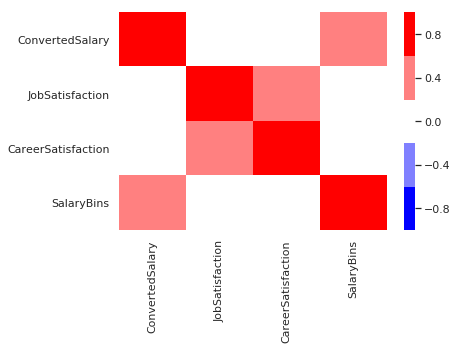

In [57]:
# correlation heatmap
cmap = plt.cm.get_cmap("bwr",lut=5) 

sns.heatmap(q_df.corr().values, vmin=-1., vmax=1.,
            cmap=cmap,
            xticklabels=list(q_df.columns),
            yticklabels=list(q_df.columns))

Looking at correlations, it looks like there's nothing really strong. Let's do some 1:1s

In [60]:
q_df['SalaryBins'].corr(q_df['JobSatisfaction'])

0.10620298642553401

In [61]:
q_df['SalaryBins'].corr(q_df['CareerSatisfaction'])

0.15827462169766443

In [62]:
q_df['JobSatisfaction'].corr(q_df['CareerSatisfaction'])

0.5797263865199026

Let's look at some averages. If `ConvertedSalary` increases mapped to JobSatisfaction increases, we'd hope for a steady climb here. IN the end, it looks like we've got a U shape. High earners at both end of the satisifcation spectrum.

In [63]:
print(q_df.groupby('JobSatisfaction').mean())

                 ConvertedSalary  CareerSatisfaction  SalaryBins
JobSatisfaction                                                 
0                  109295.736328            2.078776    2.799479
1                  101858.400889            2.600983    2.899602
2                   90321.487273            3.381176    2.743529
3                   84646.154128            3.491376    2.422752
4                   86397.174232            4.076431    2.625331
5                   97468.735781            4.763086    3.074246
6                  116340.588045            5.355175    3.526833


CareerSatisfaction has a slightly better increase, but the average `ConvertedSalary` values are really low, meaning we're not seeing a concentration of high earners at the top.

In [36]:
print(q_df.groupby('CareerSatisfaction').mean())

                    ConvertedSalary  JobSatisfaction  SalaryBins
CareerSatisfaction                                              
0                      50668.123793         1.542581    2.464442
1                      49946.077172         1.963747    2.524408
2                      50504.667326         2.727247    2.533917
3                      45692.545597         3.196086    2.309980
4                      52825.183320         3.856150    2.650538
5                      65040.835462         4.536751    3.239125
6                      69943.254357         5.181189    3.419193


Finally, by sorting via `SalaryBins`, we can see a pretty similar `JobSatisfaction` and `CareerSatisfaction` for bins the upper 50% of earners. There's a slight increase, but it seems like ConvertedSalary might be the best indicator of satisifaction.

In [37]:
print(q_df.groupby('SalaryBins').mean())

            ConvertedSalary  JobSatisfaction  CareerSatisfaction
SalaryBins                                                      
0               6767.534406         3.687141            3.872064
1              21072.252194         3.887390            3.974651
2              37900.596119         4.009454            4.115774
3              54184.712461         4.117079            4.260357
4              71104.048065         4.136935            4.366935
5              94518.845280         4.283040            4.528000
6             137935.620791         4.325850            4.670178
